# Lesson 08
Aluno: Beatriz Vieira Nascimento

Matricula: 211031628

Github:Beatrizvn

## Introdução
O trabalho a seguir tem como objetivo explorar o aprendizado de máquina aplicado à redes convolucionais e aplicar ao reconhecimento de imagens.

Para isso vou utilizar imagens de gato e tigre.


##  Configurando o Ambiente

In [4]:
# Importando Bibliotecas necessarias
import numpy as np 
import pandas as pd
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *


def search_images(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Baixando e Analisando as Imagens

Vamos realizar o downloads de uma única imagem de um "gato" usando a função download_url e exibido essas imagens em miniatura. Isso é realizado para garantir que a função está funcionando conforme o esperado. 

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


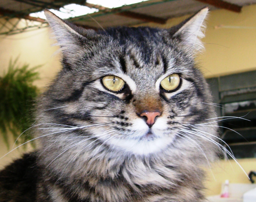

In [5]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('Gato', max_images=1)[0], 'Gato.jpg', show_progress=False)
Image.open('Gato.jpg').to_thumb(256,256)

Vamos baixar as imagens e organizar os dados usando um bloco de dados (DataBlock). Isso inclui especificar o que são as entradas (imagens) e as saídas (categorias), além de aplicar transformações nos dados e dividir tudo em conjuntos de treinamento e validação.

In [6]:
searches = 'Gato','Tigre'
path = Path('Gato_Tigre')
from time import sleep

# Download e resize das imagens
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(1)  
    resize_images(path/o, max_size=400, dest=path/o)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

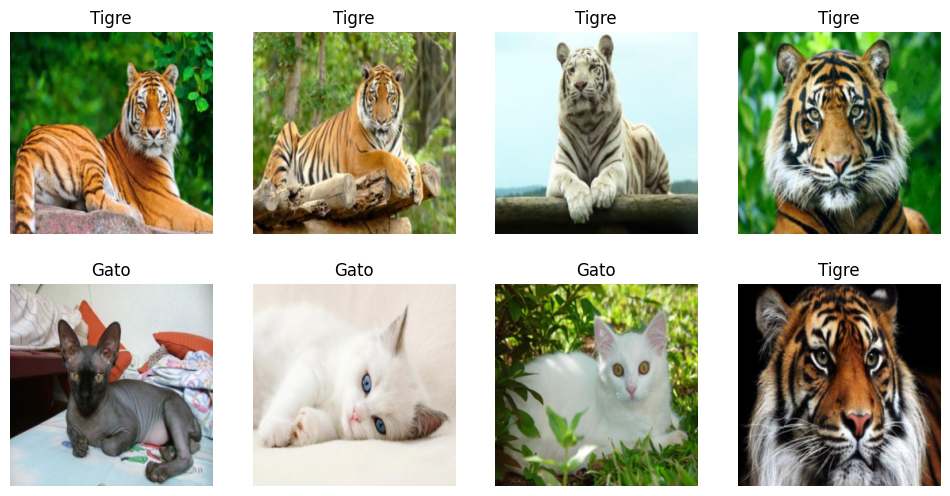

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=8)


# Convolução

A convolução é basicamente uma maneira matemática de combinar duas funções para criar uma terceira. Quando aplicada a imagens, isso significa sobrepor um filtro à imagem, multiplicando os valores ponto a ponto. Ao deslocar o filtro pela imagem, obtemos uma nova imagem transformada. A escolha e configuração do filtro podem causar efeitos como desfoque, ajuste de cores, detecção de bordas, entre outros. No exemplo abaixo, vamos criar um filtro para reduzir a saturação geral da imagem e destacar a cor vermelha.

A célula abaixo carrega uma imagem, redimensiona para 32x32 pixels, converte para um array NumPy e exibe a imagem original e a imagem redimensionada lado a lado usando a biblioteca Matplotlib.

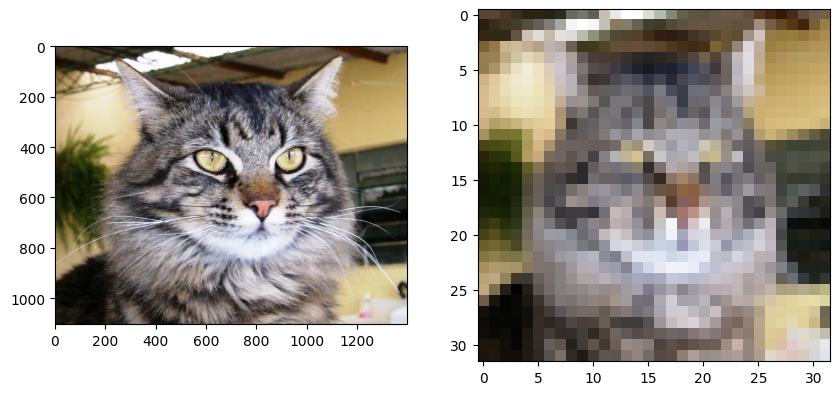

In [10]:
im = Image.open(r'/kaggle/working/Gato.jpg')
newsize = (32, 32)
im2 = im.resize(newsize)
from matplotlib import pyplot as plt
img = np.asarray(im2)
# Converter imagem para array NumPy
original = np.asarray(im, dtype=np.uint8)
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(original)
axs[1].imshow(img)

A célula abaixo define um filtro 3x3x3 (3 dimensões para as cores RGB) com valores específicos para dessaturar a imagem, mantendo uma ênfase na cor verde. Esse filtro será aplicado à imagem na célula 4.

In [11]:
filter_1 = np.zeros((3,3,3), dtype=float)

filter_1[1][1][0] = 0.4
filter_1[1][1][1] = 0.4
filter_1[1][1][2] = 0.3

A célula abaixo exibe o filtro criado na célula acima usando a Matplotlib

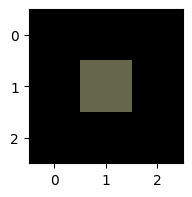

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ax.imshow(filter_1)


Na célula abaixo, um novo array img_2 é inicializado e preenchido multiplicando cada canal de cor da imagem redimensionada (img) pelos valores correspondentes do filtro. O resultado é uma nova imagem (img_2) que destaca a cor vermelha e dessatura as demais cores.

In [13]:
img_2 = np.zeros((32,32,3), dtype=float)

for i in range(32):
    for j in range(32):
        img_2[i][j][0] = img[:,:,0][i][j] * 0.4
        img_2[i][j][1] = img[:,:,1][i][j] * 0.3
        img_2[i][j][2] = img[:,:,2][i][j] * 0.3

img_2 = np.asarray(img_2, dtype=np.uint8)
np.shape(img_2)

(32, 32, 3)

A célula abaixo exibe a imagem original (img) e a imagem processada (img_2) lado a lado para comparar os efeitos da aplicação do filtro. Isso ajuda a visualizar como a convolução com o filtro modificado afeta a representação da imagem original.






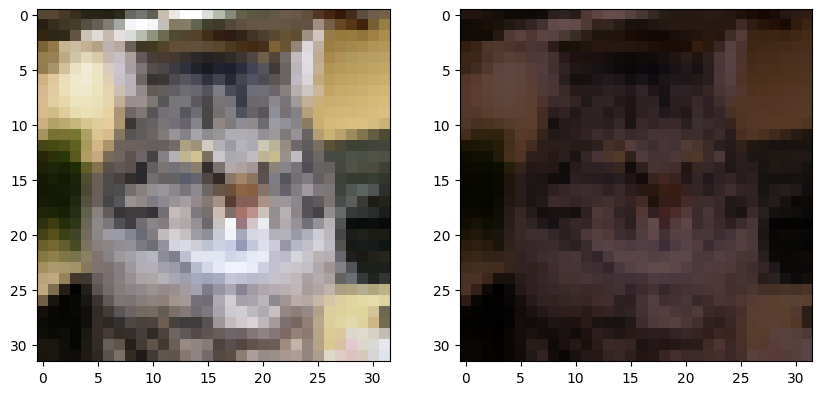

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(img)
axs[1].imshow(img_2)

## Dropout

O dropout é uma técnica comum de regularização em redes neurais, especialmente em redes convolucionais, para evitar o overfitting. O overfitting acontece quando a rede aprende padrões específicos dos dados de treinamento que não são aplicáveis a novos dados. O dropout resolve isso ao desativar aleatoriamente alguns neurônios durante o treinamento, impedindo que a rede dependa demasiadamente de neurônios específicos e, assim, melhorando a capacidade de generalização.

A função show_img na célula Abaixo é uma função que exibe uma imagem. Ela usa a biblioteca Matplotlib para mostrar uma imagem, definindo um título e desativando os eixos para melhor visualização.

In [15]:
def show_img(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

A célula abaixo contém a função dropout_np, que implementa a técnica de dropout de forma manual usando a biblioteca NumPy. A função recebe uma imagem e um fator de dropout como entrada. Ela gera um tensor aleatório do mesmo formato que a imagem e cria uma máscara binária onde os valores são 1 se forem maiores que o fator de dropout e 0 caso contrário. A imagem original é então multiplicada por essa máscara, resultando em uma nova imagem onde parte dos pixels foi "desativada".

In [17]:
def dropout_np(img, factor=0.5):
    random_tensor = np.random.rand(*img.shape)
    dropout_mask = (random_tensor > factor).astype(np.uint8)
    return img * dropout_mask

Por fim, a função show_img é usada para exibir a imagem original com o título "Imagem Original". Em seguida, a função dropout_np é aplicada à imagem original com um fator de dropout de 0.5, e a imagem resultante é exibida com o título "Imagem Com Fator de Dropout = 0.5". Esse processo demonstra visualmente como o dropout pode afetar a representação da imagem, desativando alguns dos pixels durante o treinamento. O fator de dropout de 0.5 indica que, em média, metade dos neurônios será desativada durante o treinamento.

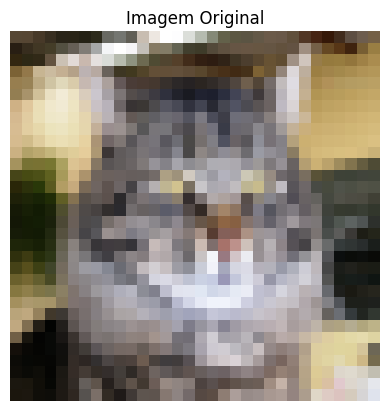

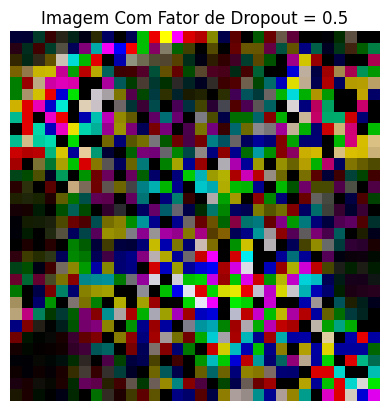

In [18]:
show_img(img, title="Imagem Original")

dropped_img = dropout_np(img)
show_img(dropped_img, title="Imagem Com Fator de Dropout = 0.5")

# Criação dos modelos

Nessa etapa serão criados 2 modelos, sendo um deles de CNN com a resnet50, por meio das funções-padrão do FastAi, E após isso um modelo manual.

## Modelo resnet50


ResNet significa Rede Residual e é um tipo específico de CNN introduzido em 2015 no artigo "Deep Residual Learning for Image Recognition" por He Kaiming e outros. O ResNet-50 é uma CNN com 50 camadas, sendo 48 convolucionais, uma MaxPool e uma de média. Redes neurais residuais são formadas empilhando blocos residuais em redes neurais artificiais.

In [20]:
learn = vision_learner(dls, resnet50)
learn.fine_tune(3)

epoch,train_loss,valid_loss,time
0,0.861015,0.081504,00:02


epoch,train_loss,valid_loss,time
0,0.166901,0.025626,00:02
1,0.109546,0.009262,00:02
2,0.101140,0.006720,00:02


## Modelo Manual

In [21]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [22]:
simple_cnn = sequential(
    conv(3 ,4),
    conv(4 ,8),
    conv(8 ,16),
    conv(16,32),
    conv(32,2, act=False),
    Flatten(),
    nn.Dropout(0.2),
)

In [23]:
learn2 = Learner(dls, simple_cnn)

In [24]:
learn2.fine_tune(10)

epoch,train_loss,valid_loss,time
0,4.816515,4.743536,00:01


epoch,train_loss,valid_loss,time
0,4.723751,4.698492,00:01
1,4.684673,4.583749,00:01
2,4.602996,4.249675,00:01
3,4.449880,3.575553,00:01
4,4.201627,2.918863,00:01
5,4.039419,2.560166,00:01
6,3.817610,2.349008,00:01
7,3.656984,2.243702,00:01
8,3.523391,2.201568,00:01
9,3.428504,2.194260,00:01


## Conclusão e Hugging face


Como podemos ver o modelo da resnet50 teve um desempenho melhor que o manual:

|       | Resnet50 | Manual |
| ----- |------------- | ------------- |
| **train_loss**  | 0.101140  |3.428504|
| **valid_loss** | 0.006720  |2.194260|

O modelo do resnet50 no hugging face:

[resnet50](https://huggingface.co/spaces/fastaioncampus/Gato-ou-Tigre)

In [25]:
learn.export('model.pkl')